In [12]:
import pandas as pd

In [13]:
df = pd.read_csv("/home/arijit/Downloads/jsw/LPR/csv_file.csv")
df.head()

,frame,status,items
0,events/RML6-ENTER-0001/1733219062368286482.jpg,NL0TQB4594,"[{""id"":""NL0TQB4594"",""type"":""truck"",""prob"":0.87..."
1,events/RML6-EXIT-0001/1733468815370782950.jpg,WB33F2942,"[{""id"":""WB33F2942"",""type"":""truck"",""prob"":0.773..."
2,events/RML1-GATE2-EXIT-0001/173346882069359793...,HR380336,"[{""id"":""HR380336"",""type"":""truck"",""prob"":0.6858..."
3,events/RML6-ENTER-0001/1733219090470262221.jpg,WB355602,"[{""id"":""WB355602"",""type"":""truck"",""prob"":0.8966..."
4,events/RML6-ENTER-0001/1733219169868597039.jpg,WB32D2192,"[{""id"":""WB32D2192"",""type"":""truck"",""prob"":0.896..."


In [14]:
import pandas as pd
import json

# Load CSV
df = pd.read_csv("csv_file.csv")

# Extract license plate bbox from JSON string in 'items'
def extract_license_plate_bbox(item_str):
    try:
        items = json.loads(item_str)
        for obj in items:
            if "items" in obj:
                for item in obj["items"]:
                    if item["type"] == "license_plate":
                        return item.get("bbox", [])
    except:
        return None

# Create new DataFrame with filename and bbox
df_bbox = pd.DataFrame({
    "filename": df["frame"].apply(lambda x: x.split("/")[-1]),
    "bbox": df["items"].apply(extract_license_plate_bbox),"status":df["status"]
})

# View the final result
print(df_bbox.head())
df_bbox.to_csv("license_plate_bboxes.csv", index=False)


                  filename                         bbox      status
0  1733219062368286482.jpg  [0.66, 0.366, 0.026, 0.032]  NL0TQB4594
1  1733468815370782950.jpg  [0.236, 0.44, 0.019, 0.024]   WB33F2942
2  1733468820693597931.jpg  [0.629, 0.842, 0.04, 0.045]    HR380336
3  1733219090470262221.jpg  [0.61, 0.397, 0.036, 0.025]    WB355602
4  1733219169868597039.jpg   [0.69, 0.328, 0.022, 0.03]   WB32D2192


In [15]:
df_bbox.shape

(102593, 3)

In [16]:
df_bbox["status"].value_counts()

status
WB29A2324     361
NL01AE0165    347
WB76A2255     287
WB33C4809     283
OD04L6825     275
             ... 
MH09BH5908      1
WB91N7819       1
WB23G0995       1
WB23B3343       1
NL046761        1
Name: count, Length: 39387, dtype: int64

In [17]:
import os
import cv2
import pandas as pd

# Define directories
image_dir = "/home/arijit/Downloads/jsw/LPR/RML1-GATE2-EXIT-0001_NVR/RML1-GATE2-EXIT-0001_NVR"
save_dir = "/home/arijit/Downloads/jsw/LPR/RML1-GATE2-EXIT-0001_NVR_crop"

# Make sure save directory exists
os.makedirs(save_dir, exist_ok=True)

# Load DataFrame
df_bbox = pd.read_csv("license_plate_bboxes.csv")

# List all filenames in the image directory
available_images = set(os.listdir(image_dir))

# Filter the DataFrame to only rows with available image files
df_matched = df_bbox[df_bbox["filename"].isin(available_images)].copy()

print(f"Total images in directory: {len(available_images)}")
print(f"Total entries in DataFrame: {len(df_bbox)}")
print(f"Matching files: {len(df_matched)}")

# Counter for saving incremental filenames
counter = 1

# Loop through matched rows and crop license plates
for idx, row in df_matched.iterrows():
    filename = row["filename"]
    bbox = row["bbox"]
    status = row["status"]

    image_path = os.path.join(image_dir, filename)

    # Ensure bbox is a valid string and parse
    if isinstance(bbox, str) and pd.notna(status):
        try:
            bbox = eval(bbox)  # Convert string to list
        except Exception as e:
            print(f"Error parsing bbox for {filename}: {e}")
            continue

        # Read the image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not read image: {image_path}")
            continue

        h, w = img.shape[:2]

        # Convert relative bbox [x, y, w, h] to absolute pixel coordinates
        x_rel, y_rel, w_rel, h_rel = bbox

        box_w = w_rel * w
        box_h = h_rel * h
        # x1 = int(x_rel * w)
        # y1 = int(y_rel * h)
        # x2 = int((x_rel + w_rel) * w)
        # y2 = int((y_rel + h_rel) * h)

        x1 = int((x_rel * w) - 0.1 * box_w)
        y1 = int((y_rel * h) - 0.1 * box_h)
        x2 = int((x_rel + w_rel) * w + 0.1 * box_w)
        y2 = int((y_rel + h_rel) * h + 0.1 * box_h)


        # Clamp to image boundaries
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(w, x2)
        y2 = min(h, y2)

        # Crop
        cropped = img[y1:y2, x1:x2]

        # Skip if crop is empty
        if cropped.size == 0:
            print(f"Empty crop for {filename}")
            continue

        # Format filename
        img_filename = f"{counter:04d}.jpg"
        txt_filename = f"{counter:04d}.txt"

        # Save image and status
        cv2.imwrite(os.path.join(save_dir, img_filename), cropped)
        with open(os.path.join(save_dir, txt_filename), 'w') as f:
            f.write(str(status))

        print(f"Saved {img_filename} and {txt_filename}")
        counter += 1


Total images in directory: 28144
Total entries in DataFrame: 102593
Matching files: 28146
Saved 0001.jpg and 0001.txt
Saved 0002.jpg and 0002.txt
Saved 0003.jpg and 0003.txt
Saved 0004.jpg and 0004.txt
Saved 0005.jpg and 0005.txt
Saved 0006.jpg and 0006.txt
Saved 0007.jpg and 0007.txt
Saved 0008.jpg and 0008.txt
Saved 0009.jpg and 0009.txt
Saved 0010.jpg and 0010.txt
Saved 0011.jpg and 0011.txt
Saved 0012.jpg and 0012.txt
Saved 0013.jpg and 0013.txt
Saved 0014.jpg and 0014.txt
Saved 0015.jpg and 0015.txt
Saved 0016.jpg and 0016.txt
Saved 0017.jpg and 0017.txt
Saved 0018.jpg and 0018.txt
Saved 0019.jpg and 0019.txt
Saved 0020.jpg and 0020.txt
Saved 0021.jpg and 0021.txt
Saved 0022.jpg and 0022.txt
Saved 0023.jpg and 0023.txt
Saved 0024.jpg and 0024.txt
Saved 0025.jpg and 0025.txt
Saved 0026.jpg and 0026.txt
Saved 0027.jpg and 0027.txt
Saved 0028.jpg and 0028.txt
Saved 0029.jpg and 0029.txt
Saved 0030.jpg and 0030.txt
Saved 0031.jpg and 0031.txt
Saved 0032.jpg and 0032.txt
Saved 0033.jpg

KeyboardInterrupt: 

In [ ]:
import os
import shutil
from datetime import date

# Set your source directory
source_dir = '/home/arijit/Downloads/jsw/LPR/lpr_crop/clear_images'

# Define the start and end numbers (inclusive)
start_num = 3006
end_num = 3306

# Format as 4-digit string (e.g., 0001, 0456)
def is_in_range(filename):
    if filename.lower().endswith('.jpg'):
        name_only = os.path.splitext(filename)[0]
        if name_only.isdigit():
            num = int(name_only)
            return start_num <= num <= end_num
    return False

# Create the output folder with today's date
today_folder = date.today().strftime('%Y-%m-%d')
output_dir = os.path.join(source_dir, today_folder)
os.makedirs(output_dir, exist_ok=True)

# Filter image files in the specified range
image_files = sorted([f for f in os.listdir(source_dir) if is_in_range(f)])

print(f"📦 Found {len(image_files)} images between {start_num:04d} and {end_num:04d}")

# Move images and corresponding .txt files
for image_name in image_files:
    base_name = os.path.splitext(image_name)[0]
    txt_name = base_name + '.txt'

    image_path = os.path.join(source_dir, image_name)
    txt_path = os.path.join(source_dir, txt_name)

    shutil.move(image_path, os.path.join(output_dir, image_name))

    if os.path.exists(txt_path):
        shutil.move(txt_path, os.path.join(output_dir, txt_name))
    else:
        print(f"⚠️ Warning: {txt_name} not found for {image_name}")

print(f"✅ Moved {len(image_files)} images and their .txt files to '{output_dir}'")


📦 Found 103 images between 3006 and 3306
✅ Moved 103 images and their .txt files to '/home/arijit/Downloads/jsw/LPR/lpr_crop/clear_images/2025-05-06'


### Python Script to Count Images and TXT Files

In [18]:
import os

# Set your root directory path
root_dir = "/home/arijit/Downloads/jsw/LPR/crop_lpr"

# Define supported image extensions
image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp")

# Initialize counters
image_count = 0
txt_count = 0

# Walk through the directory
for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.lower().endswith(image_extensions):
            image_count += 1
        elif file.lower().endswith(".txt"):
            txt_count += 1

print(f"Total number of image files: {image_count}")
print(f"Total number of .txt files: {txt_count}")


Total number of image files: 5355
Total number of .txt files: 5355


### Script to Create CSV from Image-TXT Pairs

In [ ]:
import os
import pandas as pd

# Path to your dataset
data_dir = "/home/arijit/Downloads/jsw/LPR/crop_lpr"

# Supported image extensions
image_exts = ('.jpg', '.jpeg', '.png')

# List to hold data
data = []

# Loop through files
for file in os.listdir(data_dir):
    if file.lower().endswith(image_exts):
        base_name = os.path.splitext(file)[0]
        txt_path = os.path.join(data_dir, base_name + ".txt")

        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                words = f.read().strip()
            data.append({'filename': file, 'words': words})
        else:
            print(f"Missing .txt for image: {file}")

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV
csv_output = "/home/arijit/Downloads/jsw/LPR/crop_lpr"

df.to_csv(csv_output, index=False)

print(f"CSV file created at: {csv_output}")


In [25]:
df['words']

0       ML02AN0467
1        NL02Q3584
2        NL02QB587
3        NL01R0315
4       TS12UC0739
           ...    
4214    TS12UQ0731
4215     WB49W1035
4216     ML09Q9147
4217     NL01K5326
4218     WB75A2256
Name: words, Length: 4219, dtype: object

In [26]:
# Method 1: Using value_counts() with isin()
value_counts = df['words'].value_counts()
ndf=df[df['words'].isin(value_counts[value_counts <= 10].index)]

# # Method 2: Using groupby() with transform() (more efficient for large DataFrames)
# df[df.groupby('words')['words'].transform('size') <= 5]
ndf['words'].value_counts()

words
NL01K4491     10
AP23Z5222     10
JH05DQ4522    10
AN01HB1374    10
WB33WB051     10
              ..
NL01K1165      1
DL01K4531      1
WB3BX3685      1
NL04L7331      1
WB2GA7524      1
Name: count, Length: 1741, dtype: int64

### Example Code for Resize with Aspect Ratio in Python (using OpenCV):

- Example 1

In [30]:
import cv2
import numpy as np
from skimage import exposure  # Requires scikit-image (pip install scikit-image)
import matplotlib.pyplot as plt

def enhance_license_plate(image, target_size=(200, 200)):
    """
    Enhanced pipeline for small license plate images with:
    1. Smart resizing
    2. Advanced contrast enhancement
    3. Noise-aware sharpening
    4. Edge preservation
    """
    # Convert to grayscale if needed (handle both color and grayscale inputs)
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Step 1: Smart resizing (preserve aspect ratio)
    height, width = gray.shape
    scale_factor = max(target_size[0]/width, target_size[1]/height)
    resized = cv2.resize(gray, None, fx=scale_factor, fy=scale_factor, 
                        interpolation=cv2.INTER_CUBIC)
    
    # Step 2: Adaptive histogram equalization (better than global equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(resized)
    
    # Step 3: Gamma correction (adjust based on image brightness)
    mean_brightness = np.mean(enhanced)
    gamma = 0.7 if mean_brightness > 127 else 1.3  # Darker images get brighter
    gamma_corrected = exposure.adjust_gamma(enhanced, gamma=gamma)
    
    # Step 4: Edge-preserving bilateral filter
    filtered = cv2.bilateralFilter(gamma_corrected, d=9, sigmaColor=75, sigmaSpace=75)
    
    # Step 5: Smart sharpening (only if image isn't too noisy)
    if cv2.Laplacian(filtered, cv2.CV_64F).var() > 50:  # Noise threshold
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        sharpened = cv2.filter2D(filtered, -1, kernel)
    else:
        sharpened = filtered
    
    # Step 6: Final contrast stretch
    p2, p98 = np.percentile(sharpened, (2, 98))
    final = exposure.rescale_intensity(sharpened, in_range=(p2, p98))
    
    return final

# Usage example:
image = cv2.imread('/home/arijit/Pictures/Screenshots/Screenshot from 2025-05-23 19-34-47.png', cv2.IMREAD_COLOR)
enhanced = enhance_license_plate(image)

In [12]:
import cv2

def enhance_small_text(image):
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel('/home/arijit/Downloads/jsw/LPR/EDSR_x4.pb')  # Path to model
    sr.setModel('edsr', 4)  # 4x upscaling

    # Ensure the input image has 3 channels
    if len(image.shape) == 2 or image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    upscaled = sr.upsample(image)
    return upscaled


In [13]:
enhanced =enhance_small_text(enhanced)

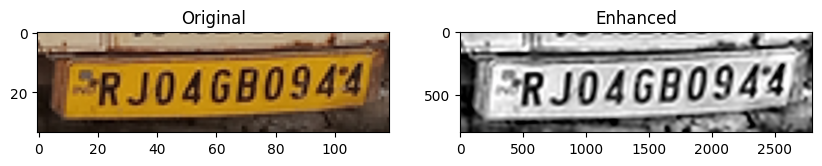

In [14]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(122), plt.imshow(enhanced, cmap='gray'), plt.title('Enhanced')
plt.show()

### Ploting the easyocr detection model:

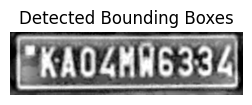

In [31]:
import cv2
import matplotlib.pyplot as plt
from easyocr import Reader
import numpy as np

# Step 1: Load and enhance your cropped plate image
image_path = '/home/arijit/Pictures/Screenshots/Screenshot from 2025-05-26 15-20-27.png'  # Replace with your actual image path
plate_crop = cv2.imread(image_path)

# If you have an enhanced image array, use it directly (don't try to read it again)
enhanced = enhance_license_plate(plate_crop)  # Uncomment if you have enhancement function
plate_crop = enhanced.copy()  # Use this if you have enhanced version

plate_crop = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2RGB)  # Convert for matplotlib

# Step 2: Initialize EasyOCR reader
reader = Reader(['en'],recog_network='custom_example', gpu=True)

# Step 3: Detect text areas
horizontal_list, free_list = reader.detect(plate_crop)

# Step 4: Draw bounding boxes on the image
# Handle horizontal_list
if horizontal_list and isinstance(horizontal_list[0], list):  # Check if it's a nested list
    for bbox in horizontal_list[0]:  # Get the first bounding box
        if isinstance(bbox, list) and len(bbox) == 4:  # Check for the expected (x, y, width, height)
            x, y, w, h = map(int, bbox)  # Convert to integers
            cv2.rectangle(plate_crop, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Handle free_list (polygon bounding boxes)
if free_list and isinstance(free_list[0], list):  # Check if it's a nested list
    for polygon in free_list[0]:  # Get the first polygon
        if isinstance(polygon, list):  # It should be a list of points
            pts = np.array(polygon, np.int32)  # Convert to a NumPy array
            pts = pts.reshape((-1, 1, 2))  # Reshape to match the expected format for polylines
            cv2.polylines(plate_crop, [pts], isClosed=True, color=(0, 0, 255), thickness=2)

# Step 5: Show the image
plt.figure(figsize=(3,6))
plt.imshow(plate_crop)
plt.axis('off')
plt.title('Detected Bounding Boxes')
plt.show()

In [12]:
print(reader.recognizer.module.FeatureExtraction.ConvNet[0].weight.shape)
# Should show torch.Size([32, 3, 3, 3])

torch.Size([32, 1, 3, 3])


### Convert White Letters to Black (Simple Inversion Method)

Avg_pixel_value:185.48294095429938


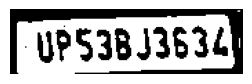

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Load the image
image = cv2.imread('/home/arijit/Pictures/Screenshots/Screenshot from 2025-06-06 18-51-07.png')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

av_pixel = np.mean(gray)
print(f'Avg_pixel_value:{av_pixel}')

# Threshold to isolate the white letters
_, thresh = cv2.threshold(gray, 190,255, cv2.THRESH_BINARY_INV)

# Invert the binary image (white letters become black)
inverted = cv2.bitwise_not(thresh)

# Merge with original background (if needed)
final = cv2.cvtColor(inverted, cv2.COLOR_GRAY2BGR)

# # Save or display
# cv2.imwrite('converted_license_plate.jpg', final)

# Step 5: Show the image
plt.figure(figsize=(3,6))
plt.imshow(final)
# plt.imshow(gray)
plt.axis('off')
# plt.title(result)
plt.show()

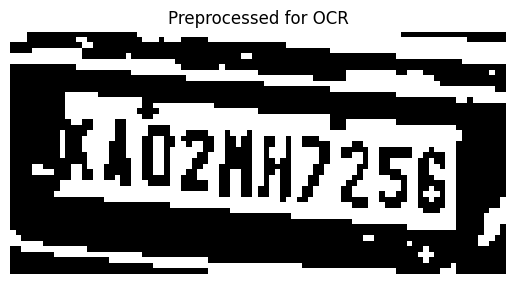

True

In [28]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load image
img = cv2.imread('/home/arijit/photo_2025-06-06_12-26-48.jpg')

# # Resize (optional, helpful for OCR models)
# img = cv2.resize(img, (300, 100))  

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Invert image (yellow becomes dark)
inverted = cv2.bitwise_not(gray)

# Threshold to make letters black and background white
_, binary = cv2.threshold(inverted, 150, 255, cv2.THRESH_BINARY_INV)

# Display the result
plt.imshow(binary, cmap='gray')
plt.title('Preprocessed for OCR')
plt.axis('off')
plt.show()

# Save for use in OCR
cv2.imwrite('preprocessed_plate.png', binary)


### Doing Prediction with custom Easyocr Model:

image_shape:(49, 150, 3)
Processing time: 0.01 seconds,text:HR26DXO830,prob:0.9515361524787058


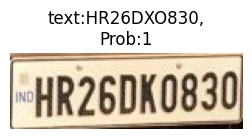

In [22]:
import easyocr
import cv2
import matplotlib.pyplot as plt



# Load the cropped license plate image
image = cv2.imread('/home/arijit/LPR_project/synthetic_data_generated/rename _data/HR26DK0830.jpg')
# image = cv2.resize(image, (600,64))
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(f'image_shape:{gray_image.shape}')


reader = easyocr.Reader(['en'],recog_network='custom_example', gpu=True,detector=False)



# reader = easyocr.Reader(['en'], model_storage_directory='/home/arijit/.EasyOCR/model',
#                         user_network_directory='/home/arijit/.EasyOCR/user_network',
#                         recog_network='custom_example',gpu=True,detector=False)


# allowlist = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
# ,allowlist=allowlist,decoder='greedy'

# Benchmark performance
import time
start = time.time()
result = reader.recognize(gray_image)
for bbox, text,prob, in result:
    if prob >0.05:

        print(f"Processing time: {time.time() - start:.2f} seconds,text:{text},prob:{prob}")

        # Step 5: Show the image
        plt.figure(figsize=(3,6))
        plt.imshow(gray_image)
        plt.axis('off')
        plt.title(f'text:{text},\nProb:{round(prob)}')
        plt.show()

- Example 2

(63, 79, 3)


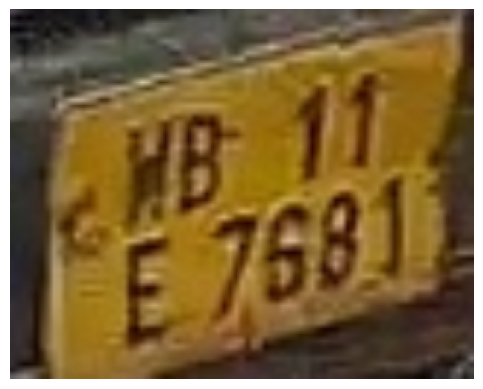

In [40]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('test/annotated_data_2/data/clean_data/Opensource_data/0024_1_1.jpg')
print(image.shape)
height, width = image.shape[:2]
new_width = 300
aspect_ratio = width / height
new_height = int(new_width / aspect_ratio)
resized_image = cv2.resize(image, (new_width, new_height))

# Convert from BGR to RGB (OpenCV uses BGR by default)
rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

# Save the resized image
cv2.imwrite('resized_license_plate_2.jpg', resized_image)

# Display with matplotlib
plt.imshow(rgb_image)
plt.axis('off')  # Hide axes
plt.show()

## Automated Image Tiering via Pixel Standard Deviation Thresholding
Description:
"This concept leverages pixel standard deviation to measure image texture and contrast variation. By analyzing these values, we can implement intelligent filtration to automatically separate high-quality (high-variance) images from low-quality (low-variance) ones. This technique is particularly useful for preprocessing datasets in computer vision tasks, ensuring optimal input quality for OCR, object detection, or other image-based AI models."
Enhanced Version (Technical):



Description:
*"The system calculates the standard deviation of pixel intensities across images to quantify their informational density. High standard deviation indicates rich texture/variation (ideal for processing), while low values suggest blurriness or low contrast. Implemented filtration includes:

Dynamic thresholding based on σ-values
- Batch processing for dataset curation
- Visual validation of segmentation results
- Applications: License plate recognition (LPR) preprocessing, medical imaging QC, and aerial imagery analysis."*

### Check Image Brightness or Contrast:

In [44]:
import cv2
import numpy as np


# Load the cropped license plate image
image = cv2.imread('/home/arijit/Downloads/jsw/LPR/crop_lpr/0001.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
# Calculate the standard deviation of pixel intensities
stddev = np.std(gray_image)

print(stddev)

35.34670996367526


### 1. Check Image Brightness or Contrast:

If the license plate is not sufficiently clear, its contrast with the background may be low. To ensure that the image has enough contrast, you can compute the average pixel intensity or the standard deviation of pixel intensities. Low standard deviation or average intensity might indicate a flat or blurry image.

Steps:

Convert the image to grayscale.

Calculate the standard deviation of pixel values.

Set a threshold for the standard deviation. If the standard deviation is below this threshold, consider the image unclear.

In [45]:
import cv2
import numpy as np

def check_image_clarity(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate the standard deviation of pixel intensities
    stddev = np.std(gray_image)
    
    # Set a threshold for clarity (this threshold might need tuning)
    if stddev > 30:  # Example threshold for clarity
        return True  # Image is clear enough
    else:
        return False  # Image is too blurry

# Load the cropped license plate image
image = cv2.imread('/home/arijit/Downloads/jsw/LPR/lpr_crop/2025-04-23/0995.jpg')

if check_image_clarity(image):
    print("Image is clear enough for recognition.")
else:
    print("Image is too blurry or unclear for recognition.")


Image is clear enough for recognition.


### 2. Check Pixel Coverage of the License Plate:

If the cropped region contains too few pixels of the actual license plate text, it might not be useful for recognition. To check if the crop is valid, you can compute the number of non-background pixels or check if the region contains a certain percentage of non-background pixels.

Steps:

- Count the number of non-zero (non-background) pixels in the cropped region.

- Set a threshold for the minimum number of non-zero pixels. If the number is too low, discard the image.

In [46]:
def check_license_plate_area(image, min_nonzero_percentage=0.2):
    # Convert to grayscale and threshold to detect text regions
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Calculate the percentage of non-zero pixels
    non_zero_pixels = cv2.countNonZero(thresh)
    total_pixels = thresh.size
    non_zero_percentage = non_zero_pixels / total_pixels

    # If the non-zero pixel percentage is below the threshold, consider the plate unclear
    if non_zero_percentage >= min_nonzero_percentage:
        return True  # Sufficient license plate pixels
    else:
        return False  # Too few license plate pixels

# Check if the cropped image has sufficient pixel coverage
if check_license_plate_area(image):
    print("Cropped image has enough license plate pixels.")
else:
    print("Cropped image does not have enough license plate pixels.")


Cropped image does not have enough license plate pixels.


### 3. Combining the Checks:

we can combine the clarity check and pixel coverage check to ensure that the cropped license plate has both sufficient clarity and pixel coverage before passing it to the recognition model. For example:

In [47]:
if check_image_clarity(image) and check_license_plate_area(image):
    print("Image is clear enough and has sufficient pixel coverage.")
    # Proceed with passing the image to the recognition model
else:
    print("Image is either too blurry or does not contain enough license plate text.")


Image is either too blurry or does not contain enough license plate text.


### 4. Pre-Processing Enhancements for Clearer Recognition:

Before passing the cropped license plate to the recognition model, you can enhance the image to ensure it has enough contrast and sharpness for recognition.

Enhancements:

- Histogram Equalization: This can increase the contrast and make the text more distinguishable from the background.

- Edge Enhancement: Using techniques like unsharp masking or applying a high-pass filter can make the text edges clearer.

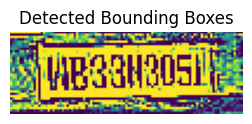

In [48]:
def enhance_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization
    enhanced_image = cv2.equalizeHist(gray)

    # Optionally apply further sharpening or edge enhancement
    kernel = np.array([[-1, -1, -1], [-1, 9,-1], [-1, -1, -1]])  # Simple sharpening filter
    sharpened_image = cv2.filter2D(enhanced_image, -1, kernel)

    return sharpened_image

enhanced_image = enhance_image(image)
#Show the image
plt.figure(figsize=(3,6))
plt.imshow(enhanced_image)
plt.axis('off')
plt.title('Detected Bounding Boxes')
plt.show()

### Testing on enhancement images:

In [49]:
import easyocr

reader = easyocr.Reader(['en'], gpu=True)

# Benchmark performance
import time
start = time.time()
result = reader.readtext(enhanced)
print(f"Processing time: {time.time() - start:.2f} seconds")

Processing time: 0.02 seconds


In [50]:
for bbox, text, confidence in result:
    print(text, confidence)

4B31NOO56 0.22051735870415037


### With the standerd deviation value i want to shepareted images and corrosponding txt file:

- To integrate both clarity and license plate area checks into the image organization process, we can modify the organize_images_by_clarity function. Specifically, we'll use the check_image_clarity and check_license_plate_area functions within the loop to check each image and only move those images that meet both criteria (clear enough and containing enough license plate pixels).


In [ ]:
import os
import cv2
import numpy as np
import shutil

def check_image_clarity(image):
    """Check if an image is clear enough based on standard deviation of pixel intensities."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    stddev = np.std(gray_image)
    return stddev > 45  # Image is clear if standard deviation is greater than the threshold

def check_license_plate_area(image, min_nonzero_percentage=0.2):
    """Check if the image has sufficient license plate area based on non-zero pixel percentage."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    non_zero_pixels = cv2.countNonZero(thresh)
    total_pixels = thresh.size
    non_zero_percentage = non_zero_pixels / total_pixels

    return non_zero_percentage >= min_nonzero_percentage  # Sufficient license plate pixels

def check_license_plate_text_sharpness(image, laplacian_thresh=200.0):
    """Check if the text on the license plate is sharp enough based on Laplacian variance."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    
    if laplacian_var > laplacian_thresh:
        return True  # Sharp text
    else:
        return False  # Text is blurred


def organize_images_by_clarity(input_dir):
    """Organize images into clear/blurry folders based on clarity check and license plate area."""
    # Create output directories if they don't exist
    clear_dir = os.path.join(input_dir, 'clear_images')
    blurry_dir = os.path.join(input_dir, 'blurry_images')
    os.makedirs(clear_dir, exist_ok=True)
    os.makedirs(blurry_dir, exist_ok=True)

    # Supported image extensions
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

    # Process each image in the input directory
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(image_extensions):
            image_path = os.path.join(input_dir, filename)
            
            try:
                # Read the image
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Could not read image: {filename}")
                    continue

                # Check image clarity and license plate area
                is_clear = check_image_clarity(image)
                has_plate_area = check_license_plate_area(image)
                edge_detection = check_license_plate_text_sharpness(image)

                # Only move the image if it meets both criteria
                if is_clear and has_plate_area and edge_detection:
                    # Determine target directory
                    target_dir = clear_dir
                    print(f"Moved {filename} to 'clear_images' folder")
                else:
                    target_dir = blurry_dir
                    print(f"Moved {filename} to 'blurry_images' folder")

                # Move the image
                shutil.move(image_path, os.path.join(target_dir, filename))

                # Move corresponding text file if it exists
                txt_filename = os.path.splitext(filename)[0] + '.txt'
                txt_path = os.path.join(input_dir, txt_filename)
                if os.path.exists(txt_path):
                    shutil.move(txt_path, os.path.join(target_dir, txt_filename))

            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    print("Organization complete!")

# Usage example
if __name__ == "__main__":
    input_directory = "/home/arijit/Downloads/jsw/LPR/lpr_crop"  # Replace with your actual path
    organize_images_by_clarity(input_directory)


Moved 6526.jpg to 'clear_images' folder
Moved 5567.jpg to 'blurry_images' folder
Moved 5899.jpg to 'blurry_images' folder
Moved 20328.jpg to 'blurry_images' folder
Moved 18914.jpg to 'blurry_images' folder
Moved 26344.jpg to 'clear_images' folder
Moved 12831.jpg to 'clear_images' folder
Moved 4130.jpg to 'blurry_images' folder
Moved 12824.jpg to 'clear_images' folder
Moved 13060.jpg to 'blurry_images' folder
Moved 23373.jpg to 'blurry_images' folder
Moved 25749.jpg to 'blurry_images' folder
Moved 10857.jpg to 'clear_images' folder
Moved 12958.jpg to 'blurry_images' folder
Moved 6076.jpg to 'clear_images' folder
Moved 26258.jpg to 'clear_images' folder
Moved 18526.jpg to 'clear_images' folder
Moved 6295.jpg to 'clear_images' folder
Moved 13652.jpg to 'clear_images' folder
Moved 14535.jpg to 'clear_images' folder
Moved 11428.jpg to 'blurry_images' folder
Moved 23264.jpg to 'blurry_images' folder
Moved 21257.jpg to 'blurry_images' folder
Moved 7833.jpg to 'clear_images' folder
Moved 12386

### license_plate_recognizer
- Here i am doing prediction on list of image directory and based on that i am save the output in a dataframe so i can analize the prediction accuraccy

In [29]:
import os
import easyocr
import pandas as pd
import time
import cv2
from tqdm import tqdm  # For progress bar

def license_plate_predictor(image_dir, output_csv="crop_lpr_predictions.csv"):
    """
    Predict license plates from all images in a directory and save results to CSV.
    
    Args:
        image_dir (str): Path to directory containing license plate images
        output_csv (str): Path to save prediction results
    """
    # Initialize EasyOCR reader
    reader = easyocr.Reader(
        ['en'],
        recog_network='custom_example',
        gpu=True,
        detector=False
    )
    
    # Collect all image files
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Process images and store results
    results = []
    for img_file in tqdm(image_files, desc="Processing images"):
        img_path = os.path.join(image_dir, img_file)
        
        # Benchmark prediction
        start_time = time.time()
        try:
            img=cv2.imread(img_path)
            gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            prediction = reader.recognize(gray_image, detail=0)
            processing_time = time.time() - start_time
            
            if prediction:  # If prediction exists
                results.append({
                    'filename': img_file,
                    'prediction': prediction[0],
                    'processing_time': processing_time
                })
            else:
                results.append({
                    'filename': img_file,
                    'prediction': '',
                    'processing_time': processing_time
                })
                
        except Exception as e:
            print(f"Error processing {img_file}: {str(e)}")
            results.append({
                'filename': img_file,
                'prediction': 'ERROR',
                'processing_time': -1
            })
    
    # Create and save DataFrame
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"\nPredictions saved to {output_csv}")
    
    # Print summary statistics
    print("\n=== Performance Summary ===")
    print(f"Total images processed: {len(df)}")
    print(f"Average processing time: {df['processing_time'].mean():.4f} sec/image")
    print(f"Fastest prediction: {df['processing_time'].min():.4f} sec")
    print(f"Slowest prediction: {df['processing_time'].max():.4f} sec")
    
    return df

# Example usage
if __name__ == "__main__":
    image_directory = "/home/arijit/LPR_project/EasyOCR/trainer/all_data/en_val"
    predictions_df = license_plate_predictor(image_directory)
    print(predictions_df.head())  # Show first few predictions

Processing images: 100%|██████████| 7977/7977 [00:36<00:00, 218.07it/s]


Predictions saved to crop_lpr_predictions.csv

=== Performance Summary ===
Total images processed: 7977
Average processing time: 0.0045 sec/image
Fastest prediction: 0.0034 sec
Slowest prediction: 0.0104 sec
         filename  prediction  processing_time
0   JH90M6280.jpg   JH90M6280         0.005221
1  GJ28QD5006.jpg  GJ28QD5006         0.004309
2  TN63UY5430.jpg  TN63UY5430         0.004429
3   MZ03P3476.jpg   MZ03P3476         0.005914
4   JH63E1428.jpg   JH63E1428         0.005884


## From prediction_csv to lable txt convertion:
    - Here with the created prediction csv file from previous code.i am generating lavel txt file for each file images

In [7]:
import csv
import os

# Input CSV file path
csv_file = 'crop_lpr_predictions.csv'
output_folder = 'license_plate_texts'  # Folder to store the text files

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Read CSV and create text files
with open(csv_file, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        # Get filename without extension and add .txt
        txt_filename = os.path.splitext(row['filename'])[0] + '.txt'
        txt_path = os.path.join(output_folder, txt_filename)
        
        # Write prediction to text file
        with open(txt_path, mode='w') as txt_file:
            txt_file.write(row['prediction'])

print(f"Successfully created {reader.line_num - 1} text files in '{output_folder}' folder.")

Successfully created 4219 text files in 'license_plate_texts' folder.


### **Now we are checking how many prediction is correct with the original groungtruth label.csv**

In [30]:
import pandas as pd
import os

def evaluate_predictions(predictions_csv, labels_csv, output_csv="prediction_evaluation.csv"):
    """
    Compare predicted license plates with ground truth labels and calculate accuracy.
    
    Args:
        predictions_csv (str): Path to CSV containing predictions (from license_plate_recognizer.py)
        labels_csv (str): Path to CSV containing ground truth labels
        output_csv (str): Path to save evaluation results
    """
    # Load data
    pred_df = pd.read_csv(predictions_csv)
    labels_df = pd.read_csv(labels_csv)
    
    # Merge dataframes on filename
    merged_df = pd.merge(pred_df, labels_df, on='filename', how='left')
    
    # Create status column (True if prediction matches ground truth)
    merged_df['status'] = merged_df['prediction'] == merged_df['words']
    
    # Calculate accuracy
    accuracy = merged_df['status'].mean() * 100
    print(f"\nOverall Accuracy: {accuracy:.2f}%")
    
    # Identify incorrect predictions
    incorrect_df = merged_df[~merged_df['status']][['filename', 'words', 'prediction']]
    print(f"\nIncorrect Predictions ({len(incorrect_df)} cases):")
    print(incorrect_df.head())  # Show first few errors
    
    # Save full results
    merged_df.to_csv(output_csv, index=False)
    print(f"\nEvaluation results saved to {output_csv}")
    
    return merged_df

# Example usage
if __name__ == "__main__":
    # Paths to your files
    predictions_file = "crop_lpr_predictions.csv"  # Output from license_plate_recognizer.py
    labels_file = "/home/arijit/LPR_project/EasyOCR/trainer/all_data/en_val/labels.csv"                 # Your ground truth file
    
    results_df = evaluate_predictions(predictions_file, labels_file)
    
    # Additional analysis
    print("\n=== Error Analysis ===")
    error_types = results_df[~results_df['status']].groupby('words').size()
    print("\nMost commonly mispredicted plates:")
    print(error_types.sort_values(ascending=False).head(10))


Overall Accuracy: 90.20%

Incorrect Predictions (782 cases):
          filename       words   prediction
8   MZ46BY0792.jpg  MZ46BY0792  MZ46BY07922
18  OR45TU6789.jpg  OR45TU6789   OR45IU6789
30  RJ89WX0123.jpg  RJ89WX0123   NL89WX0123
35  TS05IW0614.jpg  TS05IW0614   TS05IWO614
41   GA01V2345.jpg   GA01V2345    GA01Y2345

Evaluation results saved to prediction_evaluation.csv

=== Error Analysis ===

Most commonly mispredicted plates:
words
WB89Y0123     1
AN01EF2345    1
AN01RS2345    1
AN22EP5454    1
AN23PQ4567    1
AN32X0013     1
AN35VQ2494    1
AN38O5370     1
AN39DO4595    1
AN42PQ2298    1
dtype: int64


### Error Visualization

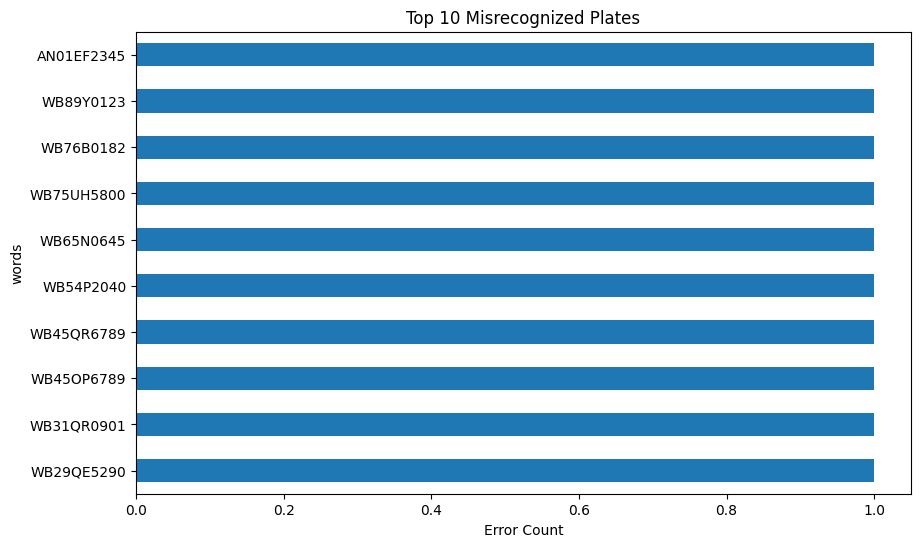

In [31]:
import matplotlib.pyplot as plt

error_df = pd.read_csv("prediction_evaluation.csv")
error_types = error_df[~error_df['status']].groupby('words').size()

plt.figure(figsize=(10,6))
error_types.sort_values().tail(10).plot(kind='barh')
plt.title("Top 10 Misrecognized Plates")
plt.xlabel("Error Count")
plt.show()

### Check Alphabet/Character Balance
- Now we need to check character balance also becuse in license plate we have balance data but need to check wither charecter also balance or not

#### Training_set:

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Load your labels
labels = pd.read_csv("test/generated_plates/generated_plate.csv")  # Columns: filename, words

# Count character frequency
char_counts = Counter("".join(labels['words']))

# Convert to Series and sort
char_series = pd.Series(char_counts).sort_values(ascending=False)

# Plot settings
plt.figure(figsize=(14, 8))
ax = char_series.plot(
    kind='barh',  # Horizontal bars
    color='#3498db',
    edgecolor='black',
    width=0.8
)

# Customize the plot
plt.title('Character Frequency Distribution Training Data', fontsize=16, pad=20)
plt.xlabel('Frequency Count', fontsize=12)
plt.ylabel('Characters', fontsize=12)

# Add value labels on bars
for i, v in enumerate(char_series):
    ax.text(v + 0.5, i, str(v), va='center', fontsize=10)

# Add grid lines
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/arijit/LPR_project/EasyOCR/trainer/all_data/en_val/home/arijit/Downloads/jsw/LPR/test/generated_plates/generated_labels.csv'

#### Validation_set:

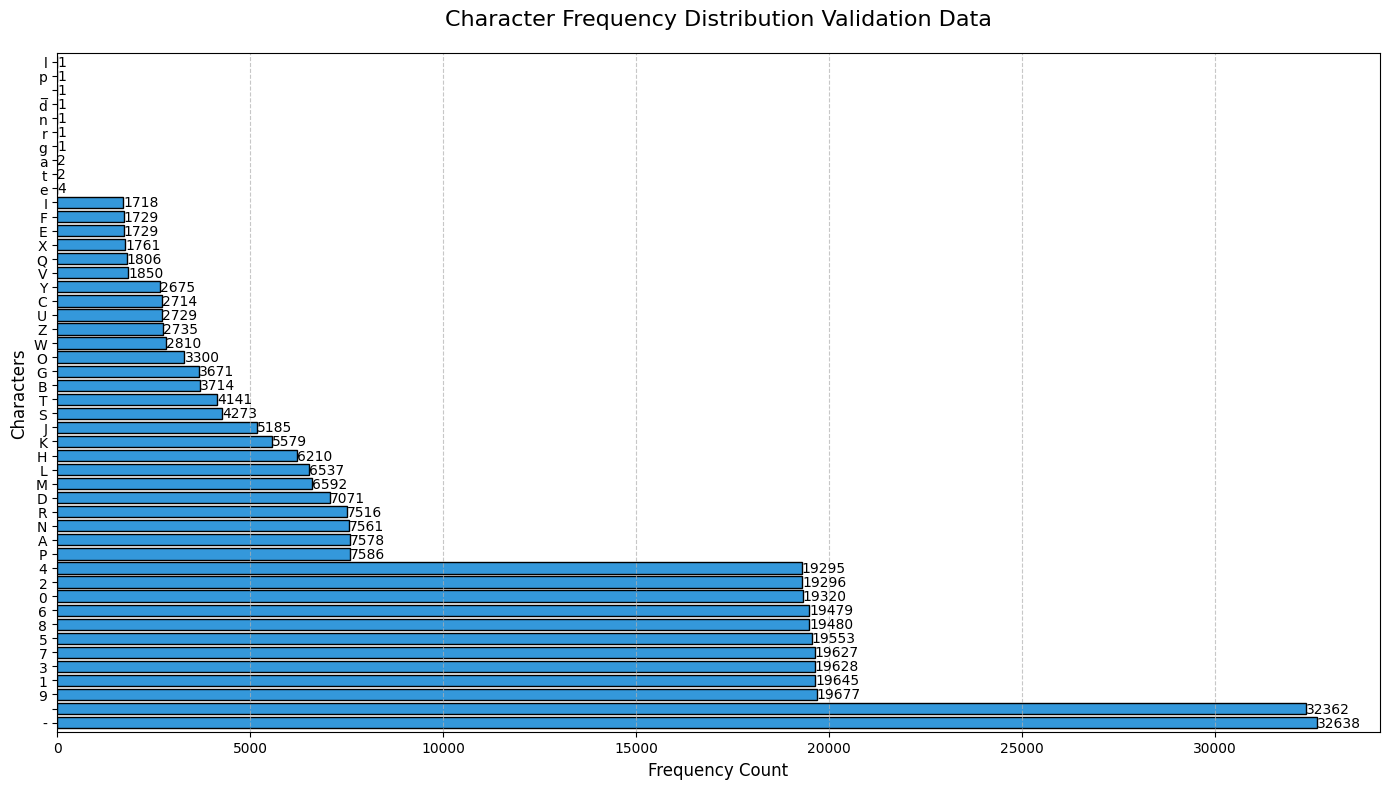

In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Load your labels
labels = pd.read_csv("/home/arijit/Downloads/jsw/LPR/test/generated_plates/generated_plate.csv")  # Columns: filename, words

# Count character frequency
char_counts = Counter("".join(labels['words']))

# Convert to Series and sort
char_series = pd.Series(char_counts).sort_values(ascending=False)

# Plot settings
plt.figure(figsize=(14, 8))
ax = char_series.plot(
    kind='barh',  # Horizontal bars
    color='#3498db',
    edgecolor='black',
    width=0.8
)

# Customize the plot
plt.title('Character Frequency Distribution Validation Data', fontsize=16, pad=20)
plt.xlabel('Frequency Count', fontsize=12)
plt.ylabel('Characters', fontsize=12)

# Add value labels on bars
for i, v in enumerate(char_series):
    ax.text(v + 0.5, i, str(v), va='center', fontsize=10)

# Add grid lines
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

### Number plate data Plot

In [2]:
import plotly.express as px
import pandas as pd
# Reding csv
df =pd.read_csv("/home/arijit/Downloads/jsw/LPR/test/generated_plates/generated_plate.csv")

# Get value counts and reset index
value_counts_df = df['words'].value_counts().reset_index()

# Check the actual column names
print("Column names:", value_counts_df.columns.tolist())  # This will likely show ['words', 'count']

# Create interactive bar plot with correct column names
fig = px.bar(
    value_counts_df,
    x='words',          # Column with plate numbers (original values)
    y='count',          # Column with counts
    title='Plate Frequency Distribution',
    labels={
        'words': 'Plate Number',  # Rename x-axis
        'count': 'Count'          # Rename y-axis
    },
    text='count'        # Display counts on bars
)

# Improve layout
fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_title='Plate Number',
    yaxis_title='Frequency Count',
    hovermode='x unified',
    height=600,
    margin=dict(b=100)  # Add bottom margin for long labels
)

# Improve bar appearance
fig.update_traces(
    marker_color='#3498db',
    marker_line_color='#1f77b4',
    marker_line_width=1.5,
    textposition='outside'
)

# Show the plot
fig.show()

Column names: ['words', 'count']


## **Finding how many state code available in the dataset**

In [ ]:
df = pd.read_csv("/home/arijit/Downloads/jsw/LPR/EasyOCR/trainer/all_data/lpr_train_filtered/labels.csv")
df.head()

,filename,words
0,1730.jpg,TS12UC0737
1,2217.jpg,NL01AB4592
2,2802.jpg,WB916609
3,0346_1.jpg,WB917819
4,1794_1.jpg,NL01G6823


In [ ]:
# Extract the first two characters as state codes
df['state_code'] = df['words'].str[:2]

# Get unique state codes
unique_state_codes = df['state_code'].unique()

print(unique_state_codes)

['TS' 'NL' 'WB' 'OD' 'HR' 'JH' 'OR' 'AP']


## **Doing Eda on both prediction and Groundtruth lable.csv file**

In [ ]:
import pandas as pd

df = pd.read_csv("/home/arijit/Downloads/jsw/LPR/crop_lpr_predictions.csv")

df.head()

,filename,prediction,processing_time
0,1730.jpg,NL02A357,0.020741
1,2217.jpg,NL0282,0.006110
2,2200.jpg,JH0536,0.006494
3,1487.jpg,NL05N374,0.005628
4,1445.jpg,NL01AB1057,0.006972


In [ ]:
df2=pd.read_csv("/home/arijit/Downloads/jsw/LPR/test/Parsed_Clear_Folder/label.csv")
df2.head()

,filename,words
0,1730.jpg,NL02AA0467
1,2217.jpg,NL02Q3587
2,2200.jpg,TS12UC0737
3,1487.jpg,TS12UC0737
4,1445.jpg,NL01AB1374


In [ ]:
result = pd.merge(df, df2, on='filename')
result=result.drop(columns="processing_time")
merged_df = result.rename(columns={'words': 'ground_truth'})
merged_df.head()


,filename,prediction,ground_truth
0,1730.jpg,NL02A357,NL02AA0467
1,2217.jpg,NL0282,NL02Q3587
2,2200.jpg,JH0536,TS12UC0737
3,1487.jpg,NL05N374,TS12UC0737
4,1445.jpg,NL01AB1057,NL01AB1374


In [56]:
merged_df[merged_df['ground_truth']!=merged_df['prediction']]

,filename,prediction,ground_truth
0,1730.jpg,NL02A357,NL02AA0467
1,2217.jpg,NL0282,NL02Q3587
2,2200.jpg,JH0536,TS12UC0737
3,1487.jpg,NL05N374,TS12UC0737
4,1445.jpg,NL01AB1057,NL01AB1374
...,...,...,...
1329,3334.jpg,WB7667736,WB76B1703
1330,2765.jpg,NL01AE615,NL01AE0165
1331,4473.jpg,WB49N19031,WB49N1039
1332,3854.jpg,JH05N06821,TS12UC0737


In [ ]:
# Save to CSV
csv_output = "/home/arijit/Downloads/jsw/LPR/Parsed_clear_folder.csv"

merged_df.to_csv(csv_output, index=False)

print(f"CSV file created at: {csv_output}")

CSV file created at: /home/arijit/Downloads/jsw/LPR/Parsed_clear_folder.csv


## **Now doing EDA on training and validation lbale.csv file**

In [47]:
import pandas as pd

train_df = pd.read_csv("/home/arijit/Downloads/jsw/LPR/EasyOCR/trainer/all_data/lpr_train_filtered/labels.csv")
vail_df = pd.read_csv("/home/arijit/Downloads/jsw/LPR/EasyOCR/trainer/all_data/lpr_val/labels.csv")

In [54]:
train_df[train_df['words']=='NL02AA0467']

,filename,words
512,0305_1.jpg,NL02AA0467
680,21505.jpg,NL02AA0467
801,17665.jpg,NL02AA0467
2065,13392.jpg,NL02AA0467
2380,0332.jpg,NL02AA0467
2708,0795.jpg,NL02AA0467
2826,0736_1.jpg,NL02AA0467
2847,8790.jpg,NL02AA0467
3227,0336.jpg,NL02AA0467
3826,0331.jpg,NL02AA0467


In [55]:
vail_df[vail_df['words']=='NL02AA0467']

,filename,words
84,28015.jpg,NL02AA0467
928,0514_1.jpg,NL02AA0467
1121,26972.jpg,NL02AA0467
1476,23816.jpg,NL02AA0467
1513,0335.jpg,NL02AA0467
1626,0334.jpg,NL02AA0467


## **Now i am checking with train data lable.csv with Parsed_clear_folder.csv to see howmany plate number is there in training data**

In [78]:
# Get unique ground_truth values from merged_df
unique_ground_truth = merged_df['ground_truth'].unique()

# Filter train_df to only show rows where 'words' matches any of these values
matching_rows = train_df[train_df['words'].isin(unique_ground_truth)]

print("Rows in train_df that match ground_truth values:")
print(matching_rows)

Rows in train_df that match ground_truth values:
        filename       words
8       7563.jpg  NL01AG6058
17      7384.jpg   WB11F1062
25    1415_2.jpg   WB37E6106
31      8889.jpg   AP23Y5222
32      6265.jpg   OD04L6823
...          ...         ...
7527  0402_1.jpg   WB37E6127
7528    8964.jpg   NL01G3625
7531    0361.jpg  JH05DN9764
7533  1461_1.jpg   OD04L6830
7535   20072.jpg   WB11D3401

[1824 rows x 2 columns]


In [84]:
matching_rows

,filename,words
8,7563.jpg,NL01AG6058
17,7384.jpg,WB11F1062
25,1415_2.jpg,WB37E6106
31,8889.jpg,AP23Y5222
32,6265.jpg,OD04L6823
...,...,...
7527,0402_1.jpg,WB37E6127
7528,8964.jpg,NL01G3625
7531,0361.jpg,JH05DN9764
7533,1461_1.jpg,OD04L6830


In [73]:
matching_rows['words'].value_counts()

words
NL01K0315     24
NL01AG6058    24
WB11F1062     24
WB37E6106     24
OD04L6826     24
              ..
WB11C7860     24
NL02Q9638     24
JH05CX3168    24
NL01G3625     24
WB49N1039     24
Name: count, Length: 76, dtype: int64

In [75]:
len(matching_rows['words'].unique())

76

In [76]:
len(merged_df['ground_truth'].unique())

77

In [85]:
# Save to CSV
csv_output = "/home/arijit/Downloads/jsw/LPR/merged.csv"

matching_rows.to_csv(csv_output, index=False)

print(f"CSV file created at: {csv_output}")

CSV file created at: /home/arijit/Downloads/jsw/LPR/merged.csv


### **Organizing Image Files by License Plate Number**

- Read a CSV file containing filenames and license plate numbers (words column)

- Create separate folders for each unique license plate number

- Copy corresponding image files to their respective folders

In [88]:
import os
import shutil
import csv

def organize_images(csv_file, images_folder, output_folder):
    """
    Organizes images into folders based on license plate numbers.
    Handles multiple files for the same plate number.
    
    Args:
        csv_file: Path to CSV file (must have 'filename' and 'words' columns)
        images_folder: Folder containing all the images
        output_folder: Where to create the organized folders
    """
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Dictionary to store plate numbers and their files
    plate_files = {}
    
    # First read all data from CSV
    with open(csv_file, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            filename = row['filename']
            plate = row['words'].strip()
            
            if not plate:
                continue
                
            if plate not in plate_files:
                plate_files[plate] = []
            plate_files[plate].append(filename)
    
    # Now process each plate number
    for plate, files in plate_files.items():
        # Create plate folder
        plate_folder = os.path.join(output_folder, plate)
        os.makedirs(plate_folder, exist_ok=True)
        
        # Copy all files for this plate
        for filename in files:
            src = os.path.join(images_folder, filename)
            dst = os.path.join(plate_folder, filename)
            
            try:
                shutil.copy2(src, dst)
                print(f"Copied {filename} to {plate}/")
            except FileNotFoundError:
                print(f"File not found: {filename}")
            except Exception as e:
                print(f"Error copying {filename}: {e}")

if __name__ == "__main__":
    # Input configuration - change these paths
    CSV_PATH = "/home/arijit/Downloads/jsw/LPR/merged.csv"          # Your CSV file path
    IMAGES_DIR = "/home/arijit/Downloads/jsw/LPR/EasyOCR/trainer/all_data/lpr_train_filtered"           # Folder with all images
    OUTPUT_DIR = "/home/arijit/Downloads/jsw/LPR/organized_plates" # Where to save organized files
    
    # Run the organizer
    print("Starting organization...")
    organize_images(CSV_PATH, IMAGES_DIR, OUTPUT_DIR)
    print("\nAll files organized successfully!")

Starting organization...
Copied 7563.jpg to NL01AG6058/
Copied 6166.jpg to NL01AG6058/
Copied 6564.jpg to NL01AG6058/
Copied 6255.jpg to NL01AG6058/
Copied 6201.jpg to NL01AG6058/
Copied 7290.jpg to NL01AG6058/
Copied 8930.jpg to NL01AG6058/
Copied 7343.jpg to NL01AG6058/
Copied 7225.jpg to NL01AG6058/
Copied 8066.jpg to NL01AG6058/
Copied 8021.jpg to NL01AG6058/
Copied 9269.jpg to NL01AG6058/
Copied 7428.jpg to NL01AG6058/
Copied 8326.jpg to NL01AG6058/
Copied 7050.jpg to NL01AG6058/
Copied 9028.jpg to NL01AG6058/
Copied 8390.jpg to NL01AG6058/
Copied 7443.jpg to NL01AG6058/
Copied 7300.jpg to NL01AG6058/
Copied 8677.jpg to NL01AG6058/
Copied 8684.jpg to NL01AG6058/
Copied 8661.jpg to NL01AG6058/
Copied 7635.jpg to NL01AG6058/
Copied 8421.jpg to NL01AG6058/
Copied 7384.jpg to WB11F1062/
Copied 9301.jpg to WB11F1062/
Copied 6450.jpg to WB11F1062/
Copied 8382.jpg to WB11F1062/
Copied 9045.jpg to WB11F1062/
Copied 9226.jpg to WB11F1062/
Copied 9013.jpg to WB11F1062/
Copied 8506.jpg to WB

### Organising directory based on ANPR Number:

In [90]:
import os
import shutil

def organize_license_plates(image_folder, txt_extension='.txt'):
    # Create a dictionary to map license plates to their files
    plate_files = {}
    
    # First pass: read all text files and collect license plate numbers
    for filename in os.listdir(image_folder):
        if filename.endswith(txt_extension):
            txt_path = os.path.join(image_folder, filename)
            
            # Read the license plate from the text file
            with open(txt_path, 'r') as f:
                license_plate = f.read().strip()
            
            # Get the corresponding image filename (assuming same base name)
            base_name = os.path.splitext(filename)[0]
            image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
            image_file = None
            
            # Find the image file with matching base name
            for ext in image_extensions:
                potential_image = base_name + ext
                if os.path.exists(os.path.join(image_folder, potential_image)):
                    image_file = potential_image
                    break
            
            if image_file:
                plate_files.setdefault(license_plate, []).append((image_file, filename))
    
    # Second pass: create folders and move files
    for plate, files in plate_files.items():
        # Create folder (sanitize plate number for filesystem)
        safe_plate = "".join(c for c in plate if c.isalnum() or c in (' ', '-', '_'))
        plate_folder = os.path.join(image_folder, safe_plate)
        
        if not os.path.exists(plate_folder):
            os.makedirs(plate_folder)
        
        # Move files to the folder
        for image_file, txt_file in files:
            src_image = os.path.join(image_folder, image_file)
            dst_image = os.path.join(plate_folder, image_file)
            
            src_txt = os.path.join(image_folder, txt_file)
            dst_txt = os.path.join(plate_folder, txt_file)
            
            shutil.move(src_image, dst_image)
            shutil.move(src_txt, dst_txt)
    
    return len(plate_files)

# Usage example:
if __name__ == "__main__":
    folder_path = "test/annotated_data_2/data/clean_data/Rashmi_LPR_annotated_data"
    unique_plates = organize_license_plates(folder_path)
    print(f"Organized {unique_plates} unique license plates into separate folders.")

Organized 134 unique license plates into separate folders.


### Python Script to Flatten a Directory Structure

In [ ]:
import os
import shutil

# Source directory containing multiple folders
source_dir = "/home/arijit/Downloads/jsw/LPR/test/annotated_data_2/data/clean_data/Parsed_Clear_Folder_1/Parsed_Clear_Folder/Parsed_Clear_Folder"

# Target directory where all files will be copied
target_dir = "/home/arijit/Downloads/jsw/LPR/test/annotated_data_2/data/clean_data/Parsed_Clear_Folder_1/Parsed_Clear_Folder/"
os.makedirs(target_dir, exist_ok=True)

# Traverse all folders and subfolders
for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg", ".txt")):  # Add/remove extensions as needed
            src_path = os.path.join(root, file)
            dst_path = os.path.join(target_dir, os.path.basename(file))

            # If file with same name exists, rename to avoid conflict
            base, ext = os.path.splitext(file)
            counter = 1
            while os.path.exists(dst_path):
                dst_path = os.path.join(target_dir, f"{base}_{counter}{ext}")
                counter += 1

            shutil.move(src_path, dst_path)

print("All files have been extracted and Moved.")


All files have been extracted and copied.


### Python Script: Move .jpg and matching .txt files

In [17]:
import os
import shutil

# Define source and destination folders
source_folder = '/home/arijit/Downloads/jsw/LPR/license_plate_texts'
destination_folder = '/home/arijit/Downloads/jsw/LPR/crop_lpr'

# Ensure destination exists
os.makedirs(destination_folder, exist_ok=True)

# Loop through all .jpg files
for filename in os.listdir(source_folder):
    if filename.lower().endswith('.jpg'):
        base_name = os.path.splitext(filename)[0]

        # Define full paths
        jpg_path = os.path.join(source_folder, base_name + '.jpg')
        # txt_path = os.path.join(source_folder, base_name + '.txt')

        dest_jpg = os.path.join(destination_folder, base_name + '.jpg')
        # dest_txt = os.path.join(destination_folder, base_name + '.txt')

        # Move .jpg
        if os.path.exists(jpg_path):
            shutil.move(jpg_path, dest_jpg)
            print(f"Moved: {jpg_path}")

        # # Move corresponding .txt if it exists
        # if os.path.exists(txt_path):
        #     shutil.move(txt_path, dest_txt)
        #     print(f"Moved: {txt_path}")


Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/1730.jpg
Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/2217.jpg
Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/2802.jpg
Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/4130.jpg
Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/2200.jpg
Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/1487.jpg
Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/1445.jpg
Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/4663.jpg
Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/0326.jpg
Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/1820.jpg
Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/5199.jpg
Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/1498.jpg
Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/1217.jpg
Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/2431.jpg
Moved: /home/arijit/Downloads/jsw/LPR/license_plate_texts/0935

### Script: Split Image + TXT Pairs into train/ and test/ Folders

This will:

- Read all .jpg files
- Shuffle and split into 80/20
- Move each image and its corresponding .txt to the correct folder

In [ ]:
import os
import shutil
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Paths (same as your original)
source_dir = "/home/arijit/Downloads/jsw/LPR/test/shorted_anotated_data/short_anotated_data/annotated_data/clear_images"
train_dir = os.path.join(source_dir, "train")
test_dir = os.path.join(source_dir, "test")

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Group files by license plate (assuming filename contains plate, e.g., "WB137154_1.jpg")
plate_to_files = defaultdict(list)
for f in os.listdir(source_dir):
    if f.lower().endswith(".jpg"):
        plate = f.split("_")[0]  # Adjust this based on your naming convention
        plate_to_files[plate].append(f)

# Stratified split: Ensure each plate appears in both train and test
train_files, test_files = [], []
for plate, files in plate_to_files.items():
    # Split files for this plate: 80% train, 20% test
    plate_train, plate_test = train_test_split(files, test_size=0.2, random_state=42)
    train_files.extend(plate_train)
    test_files.extend(plate_test)

# Move files (same as your original)
def move_files(file_list, destination):
    for img_file in file_list:
        txt_file = os.path.splitext(img_file)[0] + ".txt"
        img_src = os.path.join(source_dir, img_file)
        txt_src = os.path.join(source_dir, txt_file)
        img_dst = os.path.join(destination, img_file)
        txt_dst = os.path.join(destination, txt_file)
        if os.path.exists(img_src) and os.path.exists(txt_src):
            shutil.move(img_src, img_dst)
            shutil.move(txt_src, txt_dst)

move_files(train_files, train_dir)
move_files(test_files, test_dir)

print(f"Split complete: {len(train_files)} train, {len(test_files)} test")
print(f"Unique plates in test: {len(set(f.split('_')[0] for f in test_files))}")

### move_folders_by_last_four_digits

In [ ]:
import os
import shutil
from collections import defaultdict

def move_folders_by_last_four_digits(source_dir="."):
    # Dictionary to store folders grouped by their last 4 digits
    folders_by_last_four = defaultdict(list)
    
    # Get all directories in the source directory
    for folder_name in os.listdir(source_dir):
        folder_path = os.path.join(source_dir, folder_name)
        if os.path.isdir(folder_path) and len(folder_name) >= 4:
            last_four = folder_name[-4:]
            # Only consider if the last 4 characters are digits (optional)
            if last_four.isdigit():  # Remove this line if you want to match any 4 chars
                folders_by_last_four[last_four].append(folder_path)
    
    # Process each group of folders
    for last_four, folders in folders_by_last_four.items():
        if len(folders) > 1:  # Only if there are multiple folders with same last 4 digits
            target_dir = os.path.join(source_dir, last_four)
            
            # Create target directory if it doesn't exist
            os.makedirs(target_dir, exist_ok=True)
            
            # Move each folder to the target directory
            for folder_path in folders:
                folder_name = os.path.basename(folder_path)
                new_path = os.path.join(target_dir, folder_name)
                
                # Skip if already in the correct location
                if os.path.dirname(folder_path) != os.path.dirname(new_path):
                    shutil.move(folder_path, new_path)
                    print(f"Moved {folder_name} to {last_four}/")
                else:
                    print(f"{folder_name} already in correct location")
    
    print("Folder organization complete!")

if __name__ == "__main__":
    # You can specify a different directory as an argument if needed
    move_folders_by_last_four_digits()